# Modelovanie a Vyhodnotenie

In [31]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [32]:
df = pd.read_csv("data/data_full.csv")
df_full = df.copy()

In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from catboost import CatBoostClassifier

## Výber príznakov a príprava vstupov pre modely

In [34]:
# Zakódovanie pohlavia na číselné hodnoty 
if 'Pohlavie' in df.columns:
    df['Pohlavie'] = df['Pohlavie'].map({'M': 0, 'F': 1})

age_cols = ['Vek', 'C1', 'C3', 'C4']
blood_pressure_cols = ['A2', 'A4', 'A6', 'A8']  
pulse_cols = ['A3', 'A5', 'A7']  
# Rozdelenie tlaku na systolický a diastolický + odstránenie pôvodného stĺpca
for col in blood_pressure_cols:
    if col in df.columns:
        df[[f'{col}_systolic', f'{col}_diastolic']] = df[col].astype(str).str.extract(r'(\d+)/(\d+)').astype(float)
        df.drop(columns=[col], inplace=True)
# Konverzia pulzov na numerický typ
for col in pulse_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

block_A_cols = [
    'A2_systolic', 'A2_diastolic', 'A3',
    'A4_systolic', 'A4_diastolic', 'A5',
    'A6_systolic', 'A6_diastolic', 'A7',
    'A8_systolic', 'A8_diastolic'
]
df = df.select_dtypes(include=[float, int]).fillna(-1)
#Odstránenie cieľových stĺpcov zo vstupných údajov
if 'Synkopa' in df.columns:
    df_numeric = df.select_dtypes(include=[float, int])
    df_numeric = df_numeric.drop(columns=['Synkopa', 'Typ Synkopy'], errors='ignore')

columns_for_selection = [col for col in df.columns if col not in ["Synkopa", "Typ Synkopy"]]
#Výber príznakov pomocou RFECV

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(rf, step=1, cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1)

print("RFECV...")
rfecv.fit(df[columns_for_selection], df["Synkopa"])
selected_features = np.array(columns_for_selection)[rfecv.support_]

print(f"Optimálny počet príznakov: {rfecv.n_features_}")
print(f"Finálny zoznam príznakov: {selected_features}")

X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, df['Synkopa'], test_size=0.3, stratify=df['Synkopa'], random_state=42)
print("RFECV  XGBoost...")
xgb_rfe = RFECV(
    estimator=XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, tree_method='hist', eval_metric='logloss',random_state=42),
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1_weighted',
    n_jobs=-1
)
xgb_rfe.fit(df[columns_for_selection], df["Synkopa"])
xgb_selected_features = np.array(columns_for_selection)[xgb_rfe.support_]
print(f"Finálny zoznam príznakov XGBoost: {list(xgb_selected_features)}")

X_xgb = df[xgb_selected_features]  

X_xgb_train, X_xgb_test = train_test_split(X_xgb, test_size=0.3, stratify=df['Synkopa'], random_state=42)

RFECV...
Optimálny počet príznakov: 17
Finálny zoznam príznakov: ['Vek' 'A3' 'A5' 'A7' 'C1' 'C2' 'C3' 'C4' 'E5' 'I1' 'A2_systolic'
 'A4_systolic' 'A4_diastolic' 'A6_systolic' 'A6_diastolic' 'A8_systolic'
 'A8_diastolic']
RFECV  XGBoost...
Finálny zoznam príznakov XGBoost: ['Vek', 'A3', 'A5', 'A7', 'B5', 'C1', 'C3', 'C4', 'D1', 'D2', 'D3', 'E1', 'E5', 'E8', 'E9', 'H1', 'H2', 'H3', 'H5', 'H6', 'H8', 'H14', 'I1', 'J1', 'J2', 'K4', 'M', 'N1', 'N2', 'N7', 'O1', 'P9', 'P12', 'P17', 'P18', 'P22', 'P23', 'P31', 'P32', 'P33', 'P34', 'Q10', 'Q12', 'Q16', 'Q18', 'A2_systolic', 'A4_systolic', 'A4_diastolic', 'A6_systolic', 'A6_diastolic', 'A8_systolic']


## Konfigurácia a zostavenie modelov na predikciu Synkopy

- **Vytvoriť viacero klasifikačných modelov** (napr. Random Forest, XGBoost, KNN, Logistic Regression),
- **Použiť PCA a škálovanie**, kde je to vhodné – pri modeloch citlivých na mierku vstupov ako KNN alebo Logistic Regression,
- **Pripraviť ensemble modely**:
  - **Stacking** – kombinácia viacerých základných modelov (base learners) s meta-modelom,
  - **Voting** – jednoduché hlasovanie medzi viacerými modelmi (hard alebo soft voting),
- Cieľom je zvýšiť robustnosť a presnosť predikcie výskytu synkopy.


In [35]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# Škálovanie vstupných dát
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Redukcia dimenzie (ponecháva 99 % rozptylu)
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Náhodný les
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.5,
    max_samples=0.8,
    ccp_alpha=0.01,
    bootstrap=True,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
# Rozhodovací strom
best_dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=30,
    min_samples_leaf=20,
    class_weight='balanced',
    ccp_alpha=0.01,
    random_state=42
)
# K-najbližší susedia
best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.90)),
    ("knn", KNeighborsClassifier(
        n_neighbors=30,
        weights="distance",
        metric="euclidean"
    ))
])
# Logistická regresia
best_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.7)),
    ("lr", LogisticRegression(
        C=0.005,                  
        max_iter=500,
        penalty='l2',
        solver='lbfgs',          
        class_weight='balanced', 
        random_state=42
    ))
])
# XGBoost
best_xgb = XGBClassifier(
    colsample_bytree=0.7,
    learning_rate=0.035,
    max_depth=4,
    n_estimators=300,
    subsample=0.7,
    reg_alpha=3,
    reg_lambda=5,
    gamma=1,
    tree_method="hist",
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

models_syncope = {
    "Random Forest": best_rf,
    "Decision Tree": best_dt,
    "XGBoost": best_xgb,
    "KNN": best_knn,
    "Logistic Regression": best_lr
}
from sklearn.linear_model import RidgeClassifier
# Ensemble modely(Stacking Classifier,Voting Classifier )
stack_model_synkopa = StackingClassifier(
    estimators=[
        ("rf", best_rf),
        ("xgb", best_xgb),
        ("knn", best_knn)
    ],
    final_estimator=RidgeClassifier(alpha=1.0),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)
models_syncope["Stacking"] = stack_model_synkopa
voting_model = VotingClassifier(
    estimators=[
        ("knn", best_knn),
        ("rf", best_rf),
        ("xgb", best_xgb)
    ],
    voting="hard"
)
models_syncope["Voting"] = voting_model

## Trénovanie a vyhodnotenie modelov na predikciu synkopy
- **Natrénovať každý klasifikačný model** na príslušných vstupoch:
  - použitie škálovaných alebo PCA transformovaných dát, ak je to vhodné pre daný model,
- Získať základné **metriky presnosti**:
  - **Accuracy** – celková presnosť,
  - **Precision** – presnosť pozitívnych predikcií,
  - **Recall** – citlivosť na skutočné pozitíva,
  - **F1-score** – harmonický priemer presnosti a citlivosti,
- **Zhodnotiť ROC AUC skóre** pre modely podporujúce `predict_proba`,
- Vypočítať **priemerné F1 skóre pomocou 5-násobnej krížovej validácie** pre robustnejšie porovnanie výkonu modelov.


In [36]:
# Trénovanie všetkých modelov
for name, model in models_syncope.items():
    if name in ["Random Forest", "Decision Tree"]:
        model.fit(X_train_pca, y_train)
    elif name == "XGBoost":
        model.fit(X_xgb_train, y_train)
    else:
        model.fit(X_train, y_train)
# Vyhodnotenie metrík (na testovacej množine)
for name, model in models_syncope.items():
    if name in ["Random Forest", "Decision Tree"]:
        y_pred = model.predict(X_test_pca)
    elif name == "XGBoost":
        y_pred = model.predict(X_xgb_test)
    else:
        y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")
# ROC AUC skóre
print("\nROC AUC metriky:\n")
for name, model in models_syncope.items():
    try:
        if hasattr(model, "predict_proba"):
            if name == "XGBoost":
                y_prob = model.predict_proba(X_xgb_test)[:, 1]
            elif name in ["Random Forest", "Decision Tree"]:
                y_prob = model.predict_proba(X_test_pca)[:, 1]
            else:
                y_prob = model.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_prob)
            print(f"{name}: AUC = {auc_score:.3f}")
        else:
            print(f"{name}: predict_proba nie je dostupné")
    except Exception as e:
        print(f"{name}: chyba - {e}")
#  5-násobná krížová validácia F1 skóre
print("\nCross-validated F1 Scores (5-fold):")
for name, model in models_syncope.items():
    if name in ["Random Forest", "Decision Tree"]:
        scores = cross_val_score(model, X_train_pca, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_weighted')
    elif name == "XGBoost":
        scores = cross_val_score(model, X_xgb_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_weighted')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1_weighted')
    print(f"{name:17} - F1: {scores.mean():.3f} ± {scores.std():.3f}")

Random Forest - Accuracy: 0.723, Precision: 0.724, Recall: 0.723, F1 Score: 0.719
Decision Tree - Accuracy: 0.670, Precision: 0.672, Recall: 0.670, F1 Score: 0.670
XGBoost - Accuracy: 0.732, Precision: 0.765, Recall: 0.732, F1 Score: 0.715
KNN - Accuracy: 0.741, Precision: 0.781, Recall: 0.741, F1 Score: 0.723
Logistic Regression - Accuracy: 0.661, Precision: 0.664, Recall: 0.661, F1 Score: 0.662
Stacking - Accuracy: 0.804, Precision: 0.810, Recall: 0.804, F1 Score: 0.800
Voting - Accuracy: 0.714, Precision: 0.735, Recall: 0.714, F1 Score: 0.698

ROC AUC metriky:

Random Forest: AUC = 0.831
Decision Tree: AUC = 0.717
XGBoost: AUC = 0.856
KNN: AUC = 0.862
Logistic Regression: AUC = 0.728
Stacking: predict_proba nie je dostupné
Voting: predict_proba nie je dostupné

Cross-validated F1 Scores (5-fold):
Random Forest     - F1: 0.641 ± 0.048
Decision Tree     - F1: 0.599 ± 0.057
XGBoost           - F1: 0.682 ± 0.027
KNN               - F1: 0.709 ± 0.061
Logistic Regression - F1: 0.569 ± 0.0

## Zobrazenie matíc zámien pre modely predikcie Synkopy
- **Zobraziť matícu zámien** pre každý klasifikačný model:
  - vizualizovať počet skutočných a predikovaných prípadov **Bez Synkopy** a **Synkopa**,
  - identifikovať chyby typu **False Positive** a **False Negative**,
- **Umožniť vizuálne porovnanie medzi modelmi**:
  - ktoré modely lepšie rozlišujú medzi triedami,
  - zhodnotiť schopnosť modelu správne identifikovať pacientov so synkopou,

> Vizualizácia matíc zámien pomáha pri výbere najspoľahlivejšieho modelu z hľadiska klinickej dôležitosti (napr. minimalizácia falošných negatív).

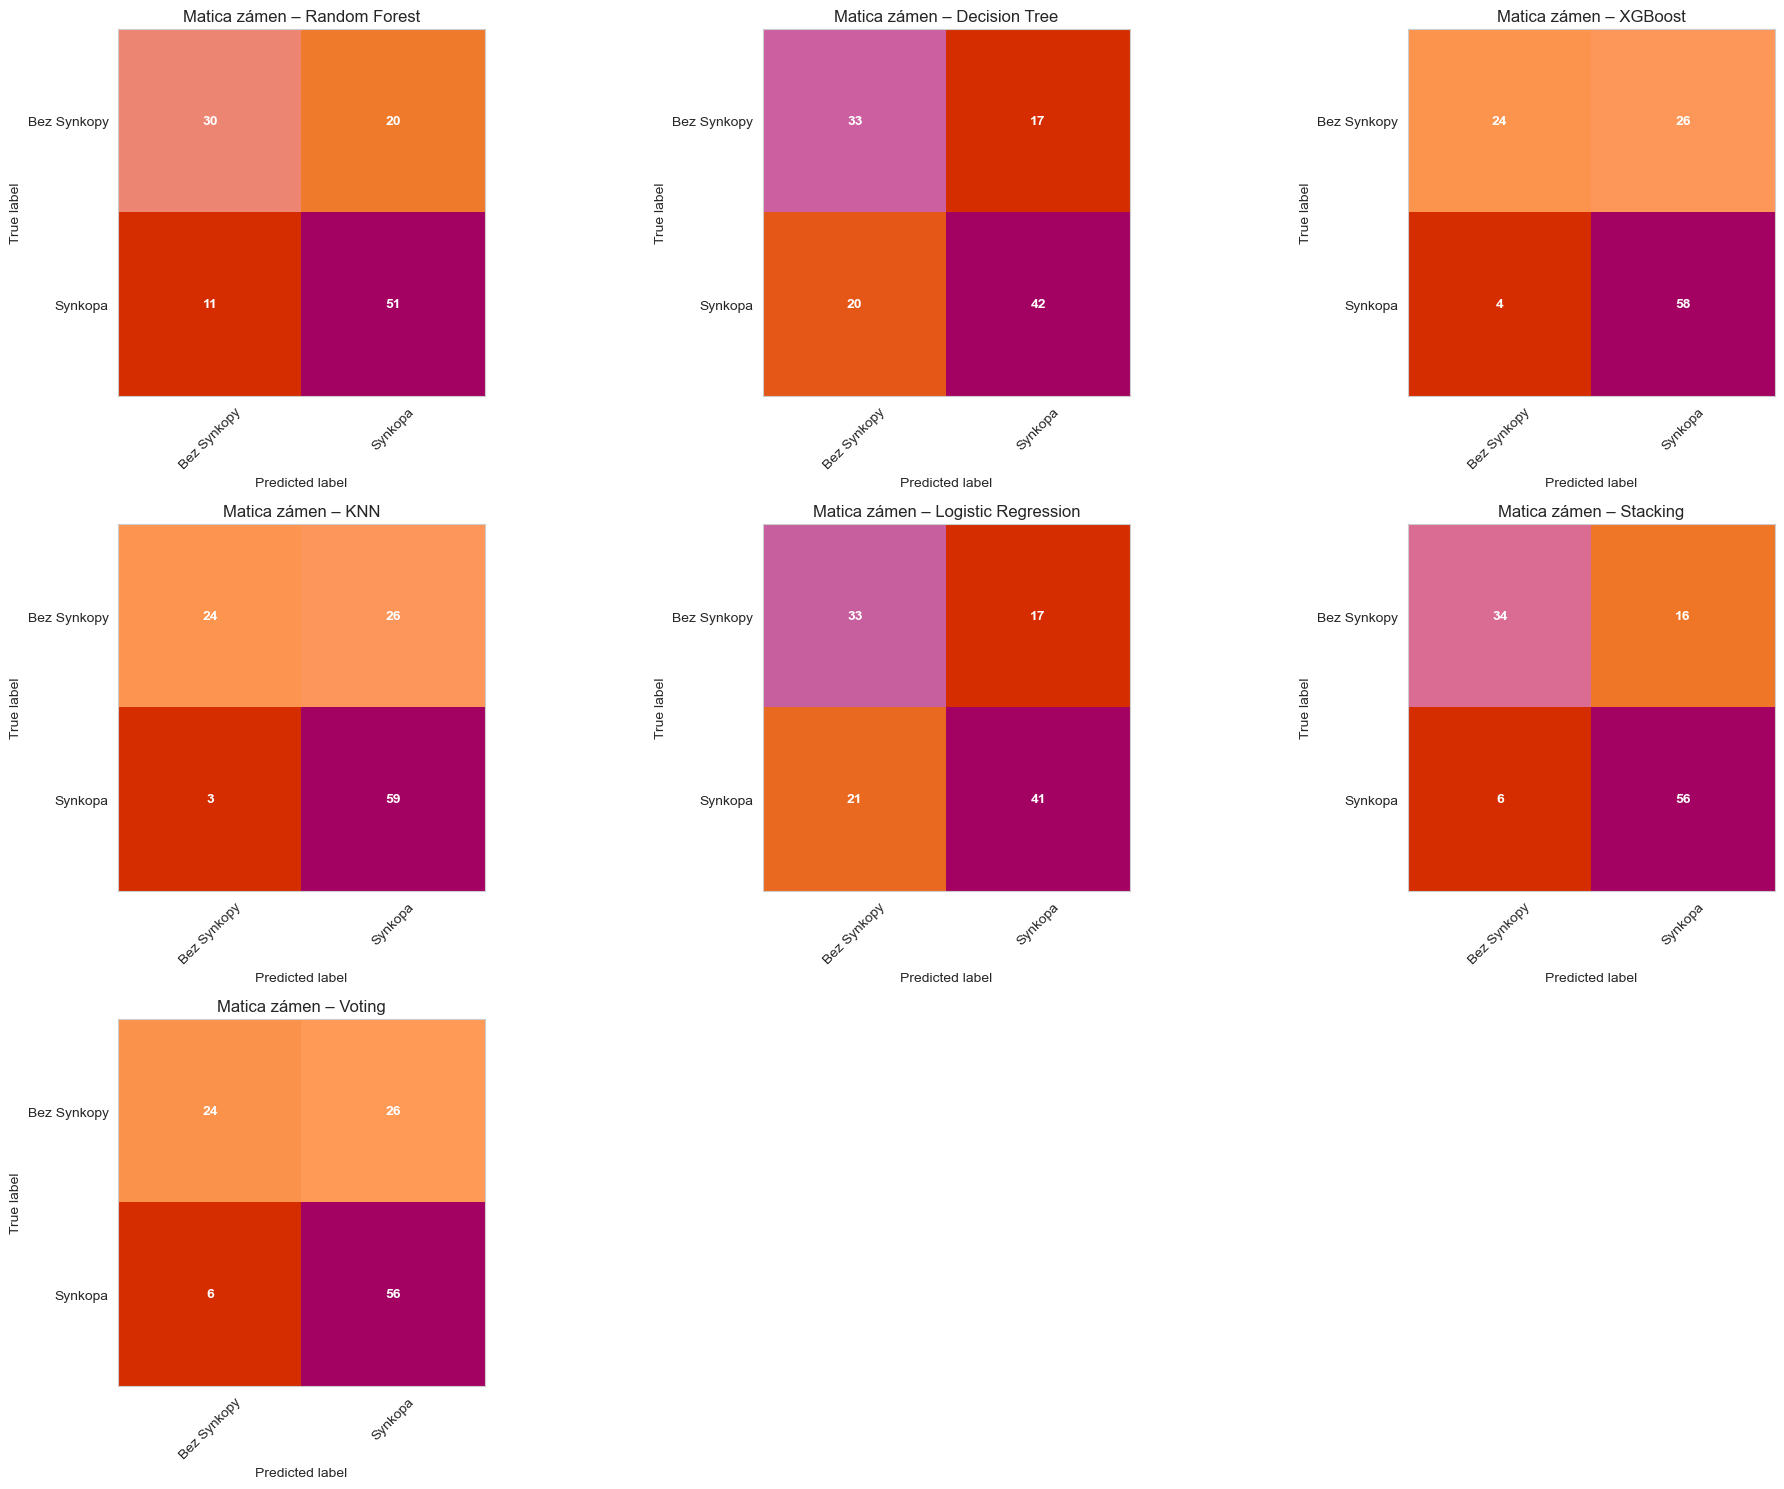

In [37]:
flag_colors = [
    "#d52d00",  
    "#ef7627",  
    "#ff9a56",  
    "#d162a4",  
    "#b55690",  
    "#a30262"   
]
from matplotlib.colors import LinearSegmentedColormap
l_cmap = LinearSegmentedColormap.from_list("lesbian_flag_no_white", flag_colors, N=256)

class_labels_binary = ["Bez Synkopy", "Synkopa"]
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_syncope.items()):
    if name in ["Random Forest", "Decision Tree"]:
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
    elif name == "XGBoost":
        model.fit(X_xgb_train, y_train)
        y_pred = model.predict(X_xgb_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_binary)
    disp.plot(ax=axes[idx], cmap=l_cmap, xticks_rotation=45, colorbar=False)
    axes[idx].grid(False) 
    for text in disp.text_.ravel():
        text.set_color("white")
        text.set_fontweight("bold")

    axes[idx].set_title(f"Matica zámen – {name}")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Význam príznakov pre predikciu Synkopy (Random Forest)
- **Získať zoznam najdôležitejších vstupných premenných** na základe atribútu `feature_importances_` z trénovaného modelu **Random Forest**,
- **Vizuálne zobraziť prínos každého príznaku**  pomocou horizontálneho barchartu,
- **Podporiť klinickú interpretáciu modelu**:
  - identifikovať symptómy, anamnestické údaje alebo fyziologické faktory, ktoré najviac ovplyvňujú rozhodnutie modelu o výskyte synkopy,
  - usmerniť odborníkov na kľúčové príznaky pri diagnostike pacientov.

> Vizualizácia významu príznakov pomáha lepšie porozumieť fungovaniu modelu a zvyšuje dôveru odborníkov v jeho výstupy.

        Feature  Importance
2            A5    0.278635
4            C1    0.095528
6            C3    0.091551
0           Vek    0.089608
3            A7    0.077317
11  A4_systolic    0.068689
1            A3    0.066364
9            I1    0.059548
10  A2_systolic    0.054020
7            C4    0.042680
8            E5    0.040835
5            C2    0.035225


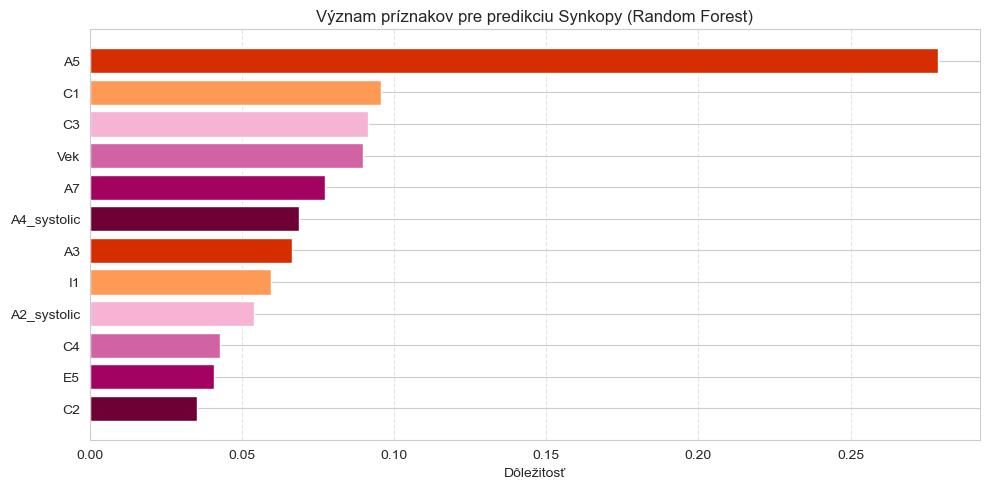

In [38]:
rf_model = models_syncope.get("Random Forest")

if rf_model and hasattr(rf_model, "feature_importances_"):
    importances_rf = rf_model.feature_importances_
    if len(selected_features) != len(importances_rf):
        selected_features = selected_features[:len(importances_rf)] 
    df_importance_rf = pd.DataFrame({
        "Feature": selected_features,
        "Importance": importances_rf
    }).sort_values("Importance", ascending=False)
    print(df_importance_rf)

    l_colors = ["#d52d00", "#ff9a56", "#f7b3d3", "#d162a4", "#a30262", "#6e0035"]
    color_cycle = (l_colors * (len(df_importance_rf) // len(l_colors) + 1))[:len(df_importance_rf)]

    plt.figure(figsize=(10, max(5, len(df_importance_rf) * 0.3)))
    plt.barh(
        df_importance_rf["Feature"],
        df_importance_rf["Importance"],
        color=color_cycle
    )
    plt.xlabel("Dôležitosť")
    plt.title("Význam príznakov pre predikciu Synkopy (Random Forest)")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Predikcia typu synkopy (Typ Synkopy) – príprava dát
- **Použiť predikciu výskytu synkopy z modelu Random Forest** a vybrať len tie záznamy, kde model predikoval hodnotu `1` (Synkopa prítomná),
- **Filtrovať iba prípady s platným typom synkopy**: `VASIS I`, `VASIS IIA`, `VASIS IIB`, `VASIS III`,
- **Zakódovať typ synkopy ako číselnú cieľovú premennú** (pomocou `LabelEncoder` alebo vlastného mapovania: I → 0, IIA → 1, IIB → 1, III → 2),
- **Vybrať najrelevantnejšie príznaky pomocou RFECV** (Recursive Feature Elimination with Cross-Validation),
- **Pripraviť dáta pre trénovanie modelov**:
  - škálovanie numerických vstupov (`StandardScaler`),
  - **vyváženie tried pomocou SMOTE** (Synthetic Minority Oversampling Technique) kvôli nevyváženému rozdeleniu typov synkopy.

> Tento krok slúži ako predpríprava pre multi-class klasifikáciu typu synkopy na základe symptómov a fyziologických údajov pacienta.


In [39]:
import numpy as np
import pandas as pd
df = df_full.copy()
# Predspracovanie
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.99)
X_features_pca = pca.fit_transform(X_features_scaled)
# Predikcia prítomnosti synkopy
df['Synkopa_predicted'] = models_syncope['Random Forest'].predict(X_features_pca)
valid_syncope_types = ["VASIS I", "VASIS IIA", "VASIS IIB", "VASIS III"]
# Filtrovanie len tých pacientov, ktorí majú predikovanú synkopu
df = df[df["Synkopa_predicted"] == 1]
df = df[df["Typ Synkopy"].isin(valid_syncope_types)]
# Mapovanie typov synkopy na číselné hodnoty
if "Typ Synkopy" in df.columns:
    syncope_mapping = {"VASIS I": 0, "VASIS IIA": 1, "VASIS IIB": 1, "VASIS III": 2, "NO CLASS": 3}
    df["Typ Synkopy"] = df["Typ Synkopy"].map(syncope_mapping)
df = df.dropna(subset=["Typ Synkopy"])
df["Typ Synkopy"] = df["Typ Synkopy"].astype(int)
all_features = df.select_dtypes(include=[np.number]).columns.tolist()

if "Synkopa" in all_features:
    all_features.remove("Synkopa")
if "Typ Synkopy" in all_features:
    all_features.remove("Typ Synkopy")
features_for_selection = [col for col in all_features if col not in ["Synkopa", "Typ Synkopy", "Synkopa_predicted"]]
df = df.select_dtypes(include=[float, int]).fillna(-1)
# Výber príznakov pre Typ Synkopy pomocou RFECV
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfecv = RFECV(rf, step=1, cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1, min_features_to_select=20)

print(" RFECV Typ Synkopy...")
rfecv.fit(df[features_for_selection], df["Typ Synkopy"])

selected_features_typ_synkopy = np.array(features_for_selection)[rfecv.support_]
print(f"Optimálny počet príznakov pre Typ Synkopy: {rfecv.n_features_}")
print(f"Finálny zoznam príznakov pre Typ Synkopy: {selected_features_typ_synkopy}")
# Príprava škálovaných vstupov
X = df[selected_features_typ_synkopy]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Typ Synkopy"].astype(int))
# Vlastné rozdelenie dát (ručne stratifikované)
i_v1 = df[df["Typ Synkopy"] == 0].index  # VASIS I
i_v2 = df[df["Typ Synkopy"] == 1].index  # VASIS II
i_v3 = df[df["Typ Synkopy"] == 2].index  # VASIS III
# Manuálny výber testovacích vzoriek pre každú triedu
test_v1 = i_v1[:40]
test_v2 = i_v2[:4]
test_v3 = i_v3[:6]

test_idx = test_v1.union(test_v2).union(test_v3)
train_idx = df.index.difference(test_idx)
# Finalizácia train/test dát
X_train = X_scaled[df.index.get_indexer(train_idx)]
X_test = X_scaled[df.index.get_indexer(test_idx)]

y_train = df.loc[train_idx, "Typ Synkopy"]
y_test = df.loc[test_idx, "Typ Synkopy"]

print(" Rozdelenie tried v y_test:", dict(zip(*np.unique(y_test, return_counts=True))))
# Vyváženie tried pomocou SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

unique_res, counts_res = np.unique(y_resampled, return_counts=True)
print(f"Rozdelenie tried po SMOTE: {dict(zip(unique_res, counts_res))}")



 RFECV Typ Synkopy...
Optimálny počet príznakov pre Typ Synkopy: 27
Finálny zoznam príznakov pre Typ Synkopy: ['Vek' 'A3' 'B2' 'C1' 'C2' 'C3' 'C4' 'D1' 'D4' 'E3' 'E7' 'H12' 'I1' 'K4'
 'N3' 'N5' 'N6' 'O1' 'P1' 'P5' 'P7' 'P9' 'P30' 'Q7' 'Q10' 'Q11' 'Q17']
 Rozdelenie tried v y_test: {0: 40, 1: 4, 2: 6}
Rozdelenie tried po SMOTE: {0: 88, 1: 88, 2: 88}


## Modely pre predikciu typu synkopy (Typ Synkopy)
- **Vytrénovať viacero klasifikačných modelov**  na dátach vyvážených pomocou **SMOTE**,
- **Vyhodnotiť výkonnosť modelov na testovacej množine** pomocou metrík:
  - `accuracy`
  - `precision`
  - `recall`
  - `f1-score`
  - `ROC AUC` ,
- **Porovnať modely pomocou 5-násobnej krížovej validácie** (`cross_val_score`)

> Cieľom je získať čo najpresnejší model


In [45]:
# Náhodný les 
best_rf_typ = RandomForestClassifier(
    n_estimators=400,         
    max_depth=8,              
    min_samples_split=5,     
    min_samples_leaf=3,      
    max_features='sqrt',      
    class_weight='balanced',  
    bootstrap=True,           
    random_state=42,
    n_jobs=-1                 
)
# XGBoost
best_xgb_typ = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    learning_rate=0.03,
    reg_alpha=0.5,
    reg_lambda=1.5,
    random_state=42,
    tree_method="hist"
)
# K-najbližší susedia
best_knn_typ = KNeighborsClassifier(
    n_neighbors=5,
    metric="manhattan",
    weights="distance"
)

models_typ_synkopy = {
    "KNN": best_knn_typ,
    "Random Forest": best_rf_typ,
    "XGBoost": best_xgb_typ,
    "Logistic Regression": LogisticRegression( 
    max_iter=1000,
    random_state=42)
}
# Stacking Classifier
stack_model_typ = StackingClassifier(estimators=[
    ('xgb', best_xgb_typ),
    ('knn', best_knn_typ),
    ('rf', best_rf_typ)
], final_estimator = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42))
models_typ_synkopy["Stacking"] = stack_model_typ
# Voting Classifier
voting_model_typ = VotingClassifier(estimators=[
    ('knn', best_knn_typ),
    ('xgb', best_xgb_typ),
    ('rf', best_rf_typ)
], voting='soft')

models_typ_synkopy["Voting"] = voting_model_typ
# Trénovanie a vyhodnotenie všetkých modelov
for name, model in models_typ_synkopy.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='weighted')
    print(f"{name} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, ROC AUC: {roc_auc:.3f}")

from sklearn.model_selection import cross_val_score
#  5-násobná krížová validácia (F1 vážené)
print("\nCross-validated F1 Scores (5-fold):")
for name, model in models_typ_synkopy.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_weighted')
    print(f"{name:17} - F1: {scores.mean():.3f} ± {scores.std():.3f}")

KNN - Accuracy: 0.900, Precision: 0.902, Recall: 0.900, F1 Score: 0.892, ROC AUC: 0.798
Random Forest - Accuracy: 0.880, Precision: 0.896, Recall: 0.880, F1 Score: 0.858, ROC AUC: 0.761
XGBoost - Accuracy: 0.860, Precision: 0.858, Recall: 0.860, F1 Score: 0.858, ROC AUC: 0.710
Logistic Regression - Accuracy: 0.760, Precision: 0.799, Recall: 0.760, F1 Score: 0.774, ROC AUC: 0.748
Stacking - Accuracy: 0.920, Precision: 0.927, Recall: 0.920, F1 Score: 0.911, ROC AUC: 0.707
Voting - Accuracy: 0.920, Precision: 0.927, Recall: 0.920, F1 Score: 0.911, ROC AUC: 0.781

Cross-validated F1 Scores (5-fold):
KNN               - F1: 0.923 ± 0.012
Random Forest     - F1: 0.947 ± 0.061
XGBoost           - F1: 0.943 ± 0.062
Logistic Regression - F1: 0.923 ± 0.030
Stacking          - F1: 0.954 ± 0.055
Voting            - F1: 0.943 ± 0.053


## Matice zámien pre predikciu Typ Synkopy 

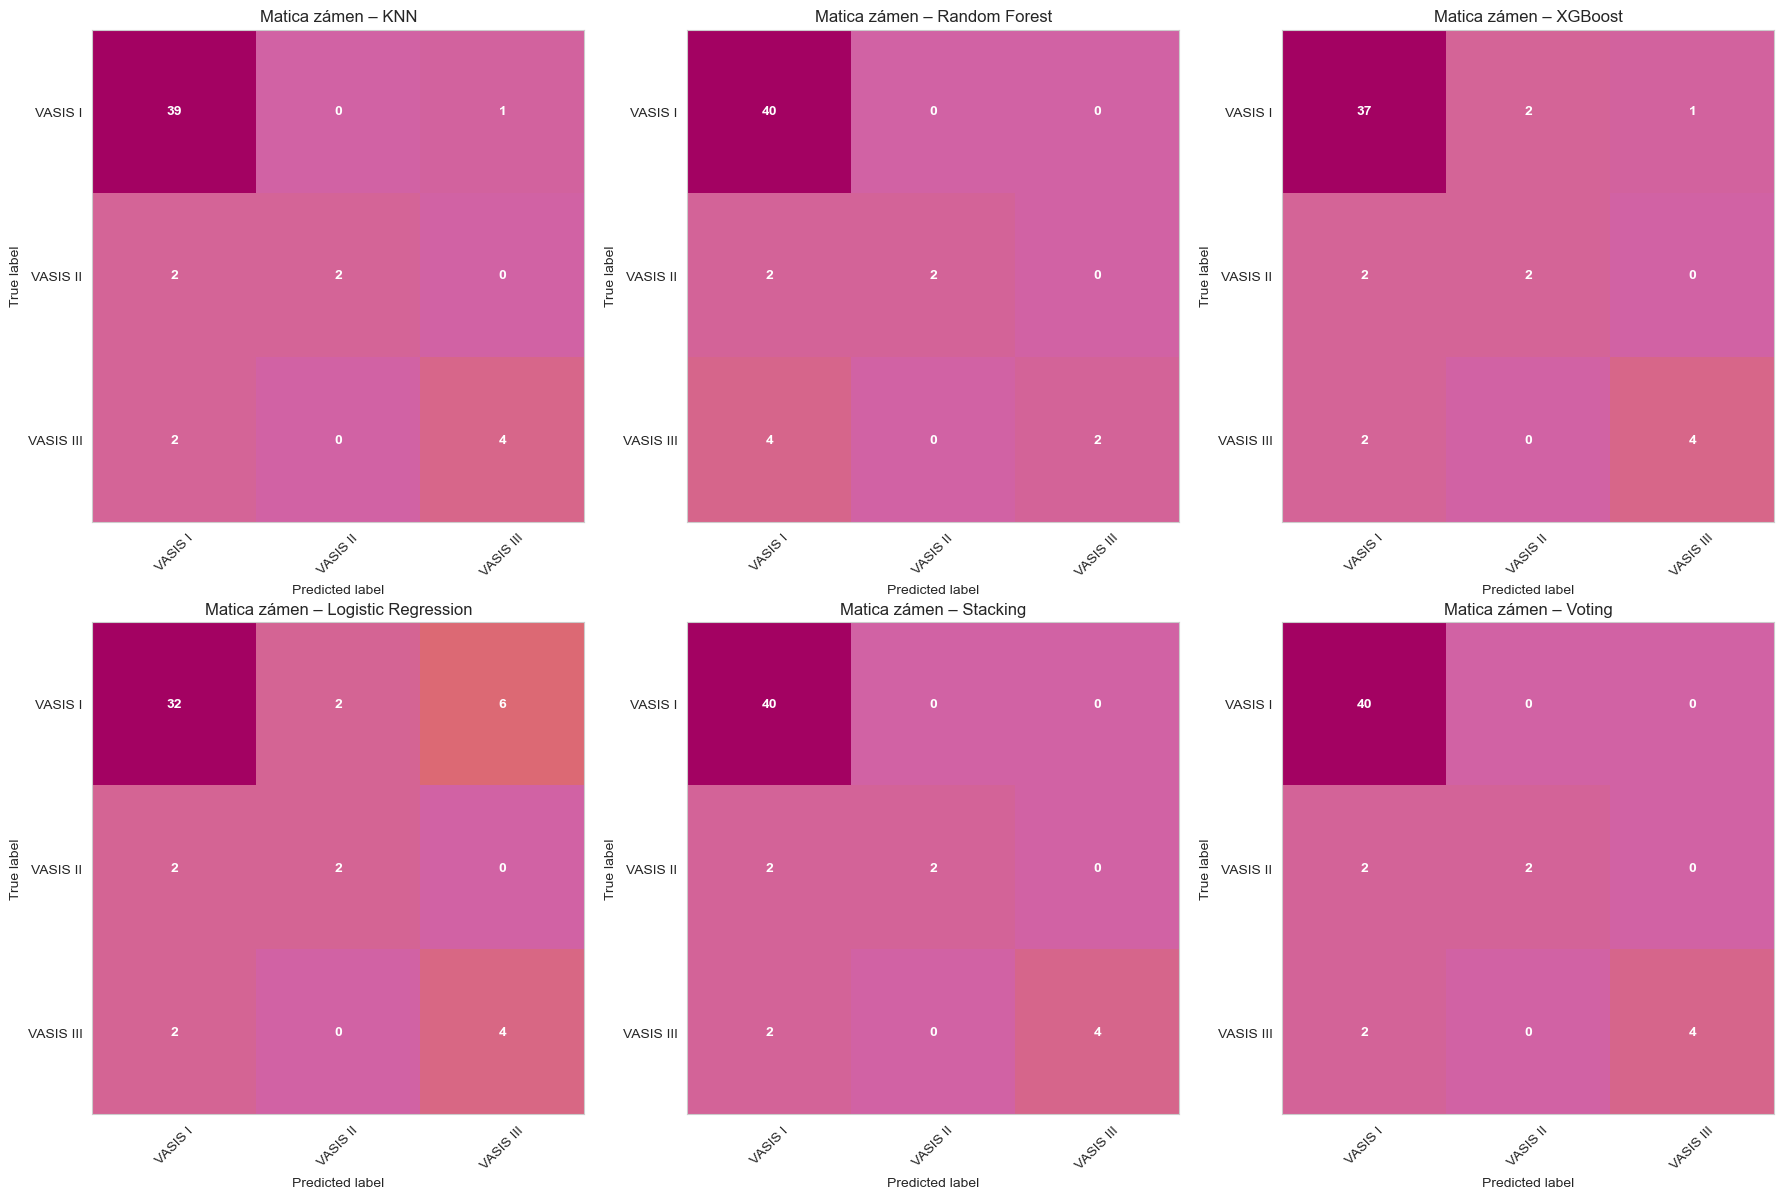

In [46]:
from matplotlib.colors import LinearSegmentedColormap

custom_gradient_colors = ["#d162a4", "#ef7627", "#a30262"]
custom_cmap = LinearSegmentedColormap.from_list("purple_pink_orange", custom_gradient_colors, N=256)
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()

class_labels = ["VASIS I", "VASIS II", "VASIS III"]
# Vizualizácia pre každý model
for idx, (name, model) in enumerate(models_typ_synkopy.items()):
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[idx], cmap=custom_cmap, xticks_rotation=45, colorbar=False)
    axes[idx].grid(False) 
    for text in disp.text_.ravel():
        text.set_color("white")
        text.set_fontweight("bold")

    axes[idx].set_title(f"Matica zámen – {name}")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Význam príznakov pre predikciu Typ Synkopy (XGBoost)


 Dôležité príznaky pre Typ Synkopy (XGBoost)
   Priznak  Dolezitost
16      N6    0.154021
2       B2    0.088990
8       D4    0.074134
3       C1    0.071276
18      P1    0.064270
23      Q7    0.059252
25     Q11    0.051894
21      P9    0.046324
15      N5    0.043671
7       D1    0.042426
24     Q10    0.034023
26     Q17    0.031107
17      O1    0.029758
14      N3    0.028700
19      P5    0.026370
4       C2    0.020416
20      P7    0.018653
0      Vek    0.015492
6       C4    0.014484
5       C3    0.014113
22     P30    0.013873
9       E3    0.013766
11     H12    0.010747
10      E7    0.009256
12      I1    0.008438
13      K4    0.007327
1       A3    0.007216


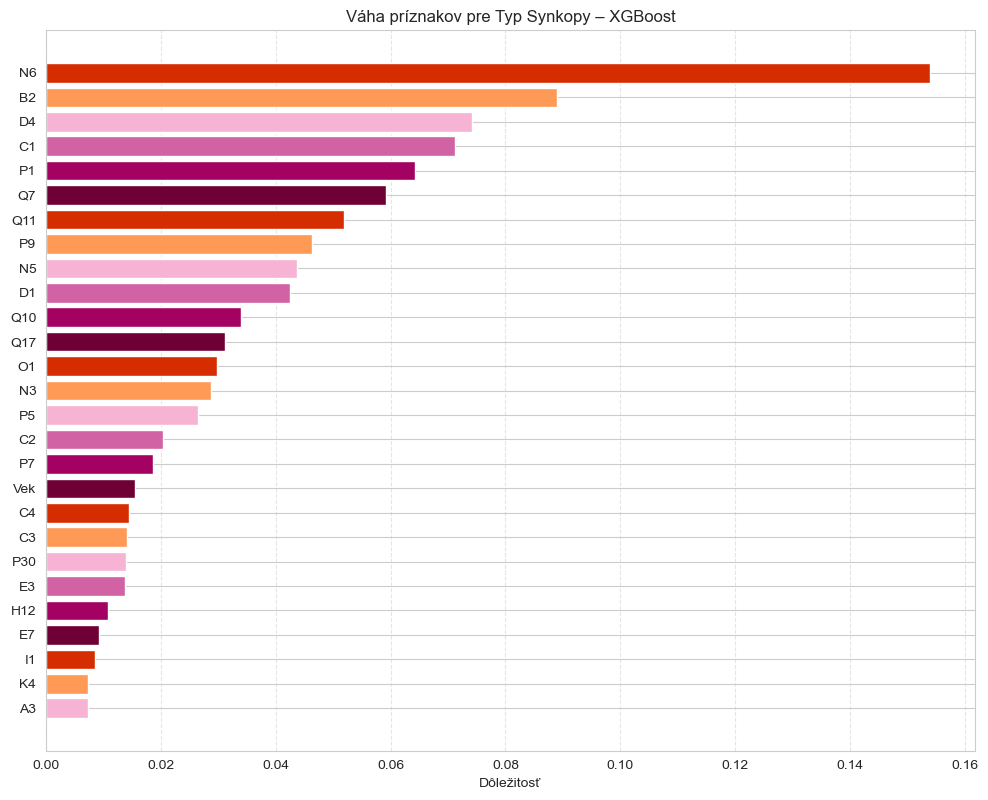

In [47]:
xgb_model = models_typ_synkopy.get("XGBoost")

if xgb_model and hasattr(xgb_model, "feature_importances_"):
    importances = xgb_model.feature_importances_
# Vytvorenie tabuľky s dôležitosťou
    df_importance = pd.DataFrame({
        "Priznak": selected_features_typ_synkopy,
        "Dolezitost": importances
    }).sort_values("Dolezitost", ascending=False)

    print("\n Dôležité príznaky pre Typ Synkopy (XGBoost)")
    print(df_importance)
# Vizualizácia dôležitosti príznakov
    l_colors = ["#d52d00", "#ff9a56", "#f7b3d3", "#d162a4", "#a30262", "#6e0035"]
    color_cycle = (l_colors * (len(df_importance) // len(l_colors) + 1))[:len(df_importance)]

    plt.figure(figsize=(10, max(5, len(df_importance) * 0.3)))
    plt.barh(
        df_importance["Priznak"],
        df_importance["Dolezitost"],
        color= color_cycle
    )
    plt.xlabel("Dôležitosť")
    plt.title("Váha príznakov pre Typ Synkopy – XGBoost")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()